# MADE, Advanced ML, HomeWork 2

Импорт нужных библиотек

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as sps
from scipy.sparse import csr_matrix
from scipy.sparse import hstack, vstack
from scipy.special import logit, expit

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import Ridge

import pickle
from copy import deepcopy
import torch

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

EPS = 1e-5
DEFAULT_PROBA = 0.0

1. Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:
взять в тренировочный набор турниры с dateStart из 2019 года; 
в тестовый — турниры с dateStart из 2020 года.


In [2]:
tournaments = pickle.load(open("chgk/tournaments.pkl", "rb"))
results = pickle.load(open("chgk/results.pkl", "rb"))
players = pickle.load(open("chgk/players.pkl", "rb"))

In [3]:
mask_translator = str.maketrans('-?', '00', 'X')
def correct_mask(mask):
    return mask.translate(mask_translator)

In [4]:
train_ids, test_ids = [] , []

train_results, test_results = dict(), dict()
for tourn_id, tourn_data in results.items():
    year = int(tournaments[tourn_id]['dateStart'][:4])
    if year not in [2019, 2020]:
        continue

    if (len(tourn_data) > 0) and ('mask' in tourn_data[0]):
        if tourn_data[0]['mask'] is None:
            continue

    if (len(tourn_data) > 0) and ('teamMembers' in tourn_data[0]):
        if tourn_data[0]['teamMembers'] is None:
            continue
            
    if len(tourn_data) < 1 or 'mask' not in tourn_data[0]:
        continue
        
    max_mask = max([len(team['mask'] or '') for team in tourn_data])
    current_data = [team for team in tourn_data if len(team['mask'] or '') == max_mask]
    
    for team in current_data:
        team['mask'] = correct_mask(team['mask'])
    if year == 2019:
        train_ids.append(tourn_id)
        train_results[tourn_id] = current_data
    else:
        test_ids.append(tourn_id)
        test_results[tourn_id] = current_data
print('Количество турниров для обучающей выборки:', len(train_results))
print('Количество турниров для тестовой выборки:',  len(test_results))

Количество турниров для обучающей выборки: 674
Количество турниров для тестовой выборки: 173


In [5]:
player_ids_train = set()
for tourn_id, tourn_data in train_results.items():

    for result in tourn_data:
        for player in result['teamMembers']:
            player_ids_train.add(player['player']['id'])
player_ids_train = list(player_ids_train)
num_of_players = len(player_ids_train)
print('Количество игроков в обучающем датасете:', num_of_players)

Количество игроков в обучающем датасете: 57423


In [7]:
def create_dataframe(results, ids):

    records = []
    for id in ids:
        result = results[id]
        for team in result:
            if 'questionsTotal' not in team:
                continue
            mask = correct_mask(team['mask'])
            for players in team['teamMembers']:
                player = players['player']
                records.append({
                    'tournament_id': id,
                    'team_id': team['team']['id'],
                    'player_id': player['id'],
                    'team_name': team['team']['name'],
                    'teamQuestions': team['questionsTotal'],
                    'player_name': '{} {} {}'.format(player['surname'], player['name'], player['patronymic']),
                    'mask': mask,
                    'mask_len': len(mask or '')
                })
    df = pd.DataFrame.from_records(records)
    df = df.merge(df.groupby('tournament_id')['mask_len'].max().rename('max_mask_len'),
                  left_on='tournament_id', right_index=True)
    df = df[df['mask_len'] == df['max_mask_len']].reset_index(drop=True)
    df.drop(['max_mask_len'], axis=1, inplace=True)
    return df

In [8]:
train_df = create_dataframe(train_results, train_ids)
test_df  = create_dataframe(test_results,  test_ids)
print('Количество записей обучающей выборки:', len(train_df))
print('Количество записей  тестовой выборки:', len(test_df))
train_df.head()

Количество записей обучающей выборки: 414746
Количество записей  тестовой выборки: 108394


,tournament_id,team_id,player_id,team_name,teamQuestions,player_name,mask,mask_len
0,4772,45556,6212,Рабочее название,28,Выменец Юрий Яковлевич,111111111011111110111111111100010010,36
1,4772,45556,18332,Рабочее название,28,Либер Александр Витальевич,111111111011111110111111111100010010,36
2,4772,45556,18036,Рабочее название,28,Левандовский Михаил Ильич,111111111011111110111111111100010010,36
3,4772,45556,22799,Рабочее название,28,Николенко Сергей Игоревич,111111111011111110111111111100010010,36
4,4772,45556,15456,Рабочее название,28,Коновалов Сергей Владимирович,111111111011111110111111111100010010,36


In [9]:
def create_df_quest_ans(train_results):
    df_quest_ans = {'q_idx': [], 't_idx': [], 'p_idx': [], 'ans': []}
    for tourn_id, tourn_data in train_results.items():
        for result in tourn_data:
            for i, ans in enumerate(result['mask']):
                q_idx = 10000 * tourn_id + i
                for player in result['teamMembers']:
                    df_quest_ans['q_idx'].append(q_idx)
                    df_quest_ans['t_idx'].append(result['team']['id'])
                    df_quest_ans['p_idx'].append(player['player']['id'])
                    df_quest_ans['ans'].append(int(ans))
    return df_quest_ans

df_quest_ans = create_df_quest_ans(train_results)
df_quest_ans = pd.DataFrame.from_dict(df_quest_ans)

In [10]:
print('Число взаимодействий игроков с вопросами в обучающем датасете:', len(df_quest_ans))
df_quest_ans.head()

Число взаимодействий игроков с вопросами в обучающем датасете: 17751584


,q_idx,t_idx,p_idx,ans
0,47720000,45556,6212,1
1,47720000,45556,18332,1
2,47720000,45556,18036,1
3,47720000,45556,22799,1
4,47720000,45556,15456,1


2. Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:

    повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;

    в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;

    для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.


### Решение:

Будем моделировать с помощью логистической регрессии вероятность того, что игрок  даст правильный ответ ans = 1 на вопрос q:
    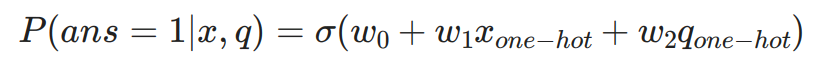

При этом используем условие, что результаты ответа команды можно отнести к результату каждого из игроков.
После завершения обучения i-я компонента вектора весов  будет содержать значение, соответствующее "силе" i-го игрока. Будем это значение интерпретировать как рейтинг. Аналогично, j-я компонента вектора весов  будет интерпретироваться как "сложность" j-го вопроса..

In [11]:
players_enc = OneHotEncoder()
questions_enc = OneHotEncoder()

X = hstack((players_enc.fit_transform(df_quest_ans['p_idx'].values.reshape(-1,1)), 
            questions_enc.fit_transform(df_quest_ans['q_idx'].values.reshape(-1,1))))
print(X.shape)

(17751584, 90656)


In [12]:
clf = LogisticRegression(random_state = 42, class_weight = 'balanced', solver='liblinear')
clf.fit(X, df_quest_ans['ans'])
clf.score(X, df_quest_ans['ans'])

0.7711515772338964

In [16]:
w0 = clf.intercept_
p_weights = clf.coef_[0, :num_of_players]
q_weights = clf.coef_[0, num_of_players:]
print('Диапазон изменения рейтингов игроков:', p_weights.min(), p_weights.max())
print('Диапазон изменения сложностей вопросов:', q_weights.min(), q_weights.max())

Диапазон изменения рейтингов игроков: -4.234217100522991 4.173462411850544
Диапазон изменения сложностей вопросов: -5.824411479020789 6.11775957096904


In [17]:
def from_weights_idx_to_player_idx(ind):
    o_h_vect = np.zeros((len(ind), num_of_players))
    for i in range(len(ind)):
        o_h_vect[i, ind[i]] = 1
    return players_enc.inverse_transform(o_h_vect).reshape(-1)

In [18]:
def from_weights_idx_to_question_idx(ind):
    o_h_vect = np.zeros((len(ind), len(q_weights)))
    for i in range(len(ind)):
        o_h_vect[i, ind[i]] = 1
    return questions_enc.inverse_transform(o_h_vect).reshape(-1)

3. Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:

 - предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;

 - в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.


Для предсказания результатов нового турнира необходимо рассчитать вероятность того, что игрок X ответит на произвольный вопрос. Это можно сделать, воспользовавшись сигмоидой, на вход которой будут подаваться выученные веса смещения w и рейтинг игрока r:
        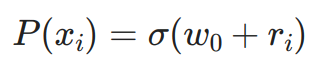

Вероятность P(T) команды ответить на вопрос равна вероятности того, что хотя бы один из игроков сможет ответить на вопрос:
        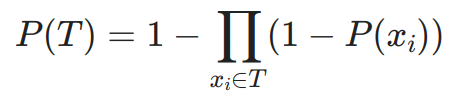

In [60]:
p_rates = pd.Series(np.zeros(num_of_players, dtype=float), index=player_ids_train)
idx = np.asarray(players_enc.transform(p_rates.index.values.reshape(-1, 1)).argmax(axis = 1)).reshape(-1)
p_rates[p_rates.index] = 1 / (1 + np.exp(-(w0 + p_weights[idx])))

In [23]:
def calc_team_proba(team, p_rates):
    result = 1
    for player in team:
        if player['player']['id'] in p_rates.index:
            p = p_rates[player['player']['id']]
        else:
            p = DEFAULT_PROBA
        result *= (1 - p)
    return 1 - result

def calc_team_naive(team, p_rates):
    result, cnt = 0, 0
    for player in team:
        if player['player']['id'] in p_rates.index:
            p = p_rates[player['player']['id']]
        else:
            p = DEFAULT_PROBA
        result += p
        cnt += 1
    if cnt == 0: result = 1
    else: result /= cnt
    return result

def calc_corr(test_results, p_rates, func):
    spearman_coef = 0
    kendall_coef = 0
    N = len(test_results)
    for tourn_id, tourn_data in test_results.items():
        if not 'position' in test_results[tourn_id][0].keys():
            continue
        ranks_pred = np.zeros(len(test_results[tourn_id]))
        ranks_true = np.zeros(len(test_results[tourn_id]))
        for i, result in enumerate(test_results[tourn_id]):
            ranks_true[i] = result['position']
            ranks_pred[i] = func(result['teamMembers'], p_rates)
        spearman_coef_curr = sps.spearmanr(ranks_pred, -ranks_true)[0]
        kendall_coef_curr  = sps.kendalltau(ranks_pred, -ranks_true)[0]
        if not (np.isnan(spearman_coef_curr) or np.isnan(kendall_coef_curr)):
            spearman_coef += spearman_coef_curr
            kendall_coef += kendall_coef_curr
    return spearman_coef / N, kendall_coef / N

In [24]:
spearman_coef, kendall_coef = calc_corr(test_results, p_rates, calc_team_proba)
print('Средняя корреляция Спирмена test:', spearman_coef)
print('Средняя корреляция Кендалла test:', kendall_coef)
spearman_coef, kendall_coef = calc_corr(test_results, p_rates, calc_team_naive)
print('Средняя корреляция Спирмена test (naive):', spearman_coef)
print('Средняя корреляция Кендалла test (naive):', kendall_coef)

Средняя корреляция Спирмена test: 0.7896588120295175
Средняя корреляция Кендалла test: 0.6348857275849283
Средняя корреляция Спирмена test (naive): 0.7756514201156461
Средняя корреляция Кендалла test (naive): 0.6191414496241937


In [28]:
TOP = 10
best_weights_id = np.argsort(p_weights)[-1:-TOP - 1:-1]
best_players_id = from_weights_idx_to_player_idx(best_weights_id)
print('Лучшие игроки по версии модели baseline и их рейтинги:')
for i in range(len(best_players_id)):
    player = players[best_players_id[i]]
    weight_id = best_weights_id[i]
    print(f"{i + 1}. {player['surname']} {player['name']} {player['patronymic']}: {p_weights[weight_id]}")

Лучшие игроки по версии модели baseline и их рейтинги:
1. Руссо Максим Михайлович: 4.173462411850544
2. Брутер Александра Владимировна: 4.050212846504839
3. Семушин Иван Николаевич: 4.006837161600024
4. Савченков Михаил Владимирович: 3.913646515365486
5. Спешков Сергей Леонидович: 3.8390835235106153
6. Сорожкин Артём Сергеевич: 3.834954270236619
7. Мереминский Станислав Григорьевич: 3.712790669936492
8. Левандовский Михаил Ильич: 3.6656151650166113
9. Прокофьева Ирина Сергеевна: 3.6154683604597286
10. Николенко Сергей Игоревич: 3.6006887960394165


4. Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:

предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;

разработайте EM-схему для обучения этой модели, реализуйте её в коде;

обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.


Решение:

 - Введем скрытую переменную: правильный ответ игрока z. Теперь, в отличие от бейзлайна, данная величина будет зависеть от результатов команды, в которой человек играет в текущий момент.

 - Если игрок  правильно ответил на вопрос, тогда и его команда правильно ответила на вопрос. Если команда на вопрос не ответила, тогда и игрок  не смог ответить на вопрос.

In [29]:
def em_alg(em_model, p, data, iters = 5):
    df_quest_ans = deepcopy(data)
    for i in range(iters):
        print(f'Итерация ЕМ-алгоритма {i + 1} из {iters}:')

        em_model.fit(X, logit(p))
        
        w0 = em_model.intercept_
        p_weights = em_model.coef_[:num_of_players]
        q_weights = em_model.coef_[num_of_players:]

        p_rates = pd.Series(np.zeros(num_of_players, dtype=float), index=player_ids_train)
        idx = np.asarray(players_enc.transform(p_rates.index.values.reshape(-1, 1)).argmax(axis = 1)).reshape(-1)
        p_rates[p_rates.index] = 1 / (1 + np.exp(-(w0 + p_weights[idx])))
        
        spearman_coef, kendall_coef = calc_corr(test_results, p_rates, calc_team_proba)
        print('Средняя корреляция Спирмена test:', spearman_coef)
        print('Средняя корреляция Кендалла test:', kendall_coef)

        p = expit(em_model.predict(X))
        df_quest_ans = df_quest_ans[['q_idx', 't_idx', 'p_idx', 'ans']]
        df_quest_ans['p'] = p
        df_quest_ans['1-p'] = 1 - df_quest_ans['p']
        df_quest_ans = df_quest_ans.merge(df_quest_ans.groupby(['q_idx', 't_idx'])['1-p'].prod().rename('z'),
                                          left_on=['q_idx', 't_idx'], right_index = True)
        df_quest_ans['z'] = df_quest_ans['p'] / (1 - df_quest_ans['z'])
        df_quest_ans['z'] = df_quest_ans['z'] * df_quest_ans['ans']
        p = np.clip(df_quest_ans['z'], EPS, 1-EPS)
   
        print()
    return w0, p_weights, q_weights

In [30]:
players_enc = OneHotEncoder()
questions_enc = OneHotEncoder()
X = hstack((players_enc.fit_transform(df_quest_ans['p_idx'].values.reshape(-1,1)), 
            questions_enc.fit_transform(df_quest_ans['q_idx'].values.reshape(-1,1))))
print(X.shape)

(17751584, 90656)


In [31]:
clf = LogisticRegression(random_state = 42, class_weight = 'balanced', solver='liblinear')
clf.fit(X, df_quest_ans['ans'])
clf.score(X, df_quest_ans['ans'])

0.7711515772338964

In [32]:
em_model = LinearRegression()
df_quest_ans = df_quest_ans[['q_idx', 't_idx', 'p_idx', 'ans']]

initial_p = clf.predict_proba(X)[:, 1] * df_quest_ans['ans'].values
initial_p = np.clip(initial_p, EPS, 1-EPS)
initial_p

array([9.89484915e-01, 9.90307098e-01, 9.91284623e-01, ...,
       1.00000000e-05, 1.00000000e-05, 1.00000000e-05])

In [33]:
#запуск em-алгоритма
w0, p_weights, q_weights = em_alg(em_model, initial_p, df_quest_ans, iters = 5)

Итерация ЕМ-алгоритма 1 из 5:
Средняя корреляция Спирмена test: 0.7942024610003388
Средняя корреляция Кендалла test: 0.6406717266535726

Итерация ЕМ-алгоритма 2 из 5:
Средняя корреляция Спирмена test: 0.7999171624060414
Средняя корреляция Кендалла test: 0.6464531507199981

Итерация ЕМ-алгоритма 3 из 5:
Средняя корреляция Спирмена test: 0.8026870474268888
Средняя корреляция Кендалла test: 0.6496744224411717

Итерация ЕМ-алгоритма 4 из 5:
Средняя корреляция Спирмена test: 0.8040096719001942
Средняя корреляция Кендалла test: 0.6509222834800521

Итерация ЕМ-алгоритма 5 из 5:
Средняя корреляция Спирмена test: 0.8043880882233918
Средняя корреляция Кендалла test: 0.651574098059334



In [36]:
w0 = em_model.intercept_
p_weights = em_model.coef_[:num_of_players]
q_weights = em_model.coef_[num_of_players:]
print('Диапазон изменения рейтингов игроков после ЕМ-алгоритма:', p_weights.min(), p_weights.max())
print('Диапазон изменения сложностей вопросов после ЕМ-алгоритма:', q_weights.min(), q_weights.max())

Диапазон изменения рейтингов игроков после ЕМ-алгоритма: -6.5989234160078505 13.184287059061214
Диапазон изменения сложностей вопросов после ЕМ-алгоритма: -8.511846037684007 18.02097932284016


### Выводы:
    
    - В ходе итераций ЕМ-алгоритма метрики качества на обучающей выборке возрастали
    - По результатам работы ЕМ-алгоритма метрики качества на тестовом датасете улучшились по сравнению с бейзлайном.
    - Диапазоны значений рейтингов игроков и сложности вопросов увеличились по сравнению с baseline-моделью.


5. А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).

In [38]:
def calc_tourn_diff(results, q_weights):
    questions_rating = {'t_id': [],'q_id': [], 'rating': []}
    for tourn_id, result in results.items():
        cur_rating = [0] * len(result[0]['mask'])
        for i in range(len(cur_rating)):
            questions_rating['t_id'].append(tourn_id)
            questions_rating['q_id'].append(10000 * tourn_id + i)
            questions_rating['rating'].append(0)
    questions_rating = pd.DataFrame(questions_rating)
    questions_rating['rating'] = q_weights
    tourn_diff = questions_rating.groupby(['t_id'])[['t_id', 'rating']].mean().reset_index(drop=True)
    return tourn_diff.sort_values(by = ['rating'])

In [39]:
q_weights = clf.coef_[0, num_of_players:]
tournament_diffs = calc_tourn_diff(train_results, q_weights)

print('Самые сложные турниры baseline-модели:')
for i, tourn_name in enumerate(tournament_diffs['t_id'][:10]):
    print(f'{i + 1:2}. {tournaments[tourn_name]["name"]}')
print()
print('Самые простые турниры baseline-модели:')
for i, tourn_name in enumerate(tournament_diffs['t_id'][-1:-11:-1]):
    print(f'{i + 1:2}. {tournaments[tourn_name]["name"]}')

Самые сложные турниры baseline-модели:
 1. Чемпионат Санкт-Петербурга. Первая лига
 2. Угрюмый Ёрш
 3. Синхрон высшей лиги Москвы
 4. Первенство правого полушария
 5. Воображаемый музей
 6. Записки охотника
 7. Кубок городов
 8. Знание – Сила VI
 9. Ускользающая сова
10. Чемпионат России

Самые простые турниры baseline-модели:
 1. (а)Синхрон-lite. Лига старта. Эпизод V
 2. (а)Синхрон-lite. Лига старта. Эпизод III
 3. (а)Синхрон-lite. Лига старта. Эпизод IX
 4. Синхрон Лиги Разума
 5. (а)Синхрон-lite. Лига старта. Эпизод VII
 6. Школьный Синхрон-lite. Выпуск 2.5
 7. (а)Синхрон-lite. Лига старта. Эпизод IV
 8. Студенческий чемпионат Калининградской области
 9. Школьная лига. I тур.
10. Школьная лига


### Вывод:

 - Рейтинг-листы ЕМ-модели достаточно хорошо соответствуют интуиции: самые сложные по ее версии турниры - это чемпионаты мира и России. Самые простые - школьные лиги и Синхрон-lite.
 
 - ЕМ-модель гораздо лучше выучивает сложности вопросов, чем baseline-модель.

6. Бонус: постройте топ игроков по предсказанной вашей моделью силе игры, а рядом с именами игроков напишите общее число вопросов, которое они сыграли. Скорее всего, вы увидите, что топ занят игроками, которые сыграли совсем мало вопросов, около 100 или даже меньше; если вы поищете их в официальном рейтинге ЧГК, вы увидите, что это какие-то непонятные ноунеймы. В baseline-модели, скорее всего, такой эффект будет гораздо слабее.

Это естественное свойство модели: за счёт EM-схемы влияние 1-2 удачно сыгранных турниров будет только усиливаться, потому что неудачных турниров, чтобы его компенсировать, у этих игроков нет. Более того, это не мешает метрикам качества, потому что если эти игроки сыграли всего 1-2 турнира в 2019-м, скорее всего они ничего или очень мало сыграли и в 2020, и их рейтинги никак не влияют на качество тестовых предсказаний. Но для реального рейтинга такое свойство, конечно, было бы крайне нежелательным. Давайте попробуем его исправить:

 - сначала жёстко: выберите разумную отсечку по числу вопросов, учитывая, что в одном турнире их обычно 30-50;
можно ли просто выбросить игроков, которые мало играли, и переобучить модель? почему? предложите, как нужно изменить модель, чтобы не учитывать слишком мало сыгравших, и переобучите модель;

 - но всё-таки это не слишком хорошее решение: если выбрать маленькую отсечку, будут ноунеймы в топе, а если большую, то получится, что у нового игрока слишком долго не будет рейтинга; скорее всего, никакой “золотой середины” тут не получится;

 - предложите более концептуальное решение для топа игроков в рейтинг-листе; если получится, реализуйте его на практике (за это уж точно будут серьёзные бонусные баллы).


In [37]:
def calc_player_rates(train_df, p_weights):
    p_rates_em = train_df[['player_id', 'player_name']].drop_duplicates('player_id').reset_index(drop=True).copy()
    p_rates_em = p_rates_em.merge(train_df.groupby('player_id')['mask_len'].sum().rename('num_q'),
                                  left_on='player_id', right_index=True)
    idx = np.asarray(players_enc.transform(p_rates_em['player_id'].values.reshape(-1, 1)).argmax(axis = 1)).reshape(-1)
    p_rates_em['rating'] = p_weights[idx]
    return p_rates_em.sort_values('rating', ascending=False).reset_index(drop=True)

p_rates_em = calc_player_rates(train_df, p_weights)
p_rates_em.head(15)

,player_id,player_name,num_q,rating
0,38175,Пилипенко Максим Игоревич,36,13.184287
1,22474,Немец Илья Сергеевич,75,11.832314
2,199963,Бровченко Елена Борисовна,36,11.521486
3,14996,Козлова Ольга Александровна,36,10.229846
4,202410,Подюкова Валентина,36,10.134855
5,133504,Лебедева София Евгеньевна,36,9.944602
6,121433,Савенко София Романовна,36,9.816488
7,212663,Губина Майя Александровна,72,9.724489
8,4876,Вакуленко Владимир Сергеевич,36,9.447781
9,123750,Завьялов Сергей Андреевич,36,9.059117


In [38]:
p_rates_em.sort_values('rating', ascending=False).reset_index(drop=True).head(15)

,player_id,player_name,num_q,rating
0,38175,Пилипенко Максим Игоревич,36,13.184287
1,22474,Немец Илья Сергеевич,75,11.832314
2,199963,Бровченко Елена Борисовна,36,11.521486
3,14996,Козлова Ольга Александровна,36,10.229846
4,202410,Подюкова Валентина,36,10.134855
5,133504,Лебедева София Евгеньевна,36,9.944602
6,121433,Савенко София Романовна,36,9.816488
7,212663,Губина Майя Александровна,72,9.724489
8,4876,Вакуленко Владимир Сергеевич,36,9.447781
9,123750,Завьялов Сергей Андреевич,36,9.059117


In [39]:
CUT_OFF = 1000
p_rates_em[p_rates_em['num_q'] > CUT_OFF].sort_values('rating', ascending=False).reset_index(drop=True).head(20)

,player_id,player_name,num_q,rating
0,27403,Руссо Максим Михайлович,2178,8.339926
1,7008,Гилёв Алексей Владимирович,4450,7.904306
2,4270,Брутер Александра Владимировна,2692,7.884845
3,28751,Семушин Иван Николаевич,3774,7.880107
4,15727,Коробейников Александр Геннадьевич,1401,7.852995
5,30152,Сорожкин Артём Сергеевич,4849,7.822918
6,20691,Мереминский Станислав Григорьевич,1584,7.770636
7,27822,Савченков Михаил Владимирович,3215,7.717139
8,18332,Либер Александр Витальевич,3789,7.492296
9,74001,Мокин Игорь Викторович,1176,7.423891


С учетом отсечки рейтинг-лист выглядит существенно лучше.
Что можно сделать для улучшения системы ранжирования игроков? Рассмотрм несколько вариантов:

1. Отбрасывание игроков, сыгравших малое количество вопросов.

 - Этот вариант не очень хорош по следующим причинам:
        а) при отбрасывании вносится смещение в выборку, поскольку ответы игроков зависят от ответов других членов команды;
        б) теряется информация об игроках;

2. Сглаживание исходных данных.

 - Для снижения эффекта влияния 1-2 удачно сыгранных турниров на рейтинг можно для всех игроков ввести некоторое количество (например 100) фиктивных вопросов, на которые никто не ответил правильно.

С одной стороны, на сильных игроков это не окажет заметного влияния, с другой стороны не позволит удачливым новичкам набрать высокие баллы.

In [41]:
df_quest_ans = create_df_quest_ans(train_results)
FICT_QUEST = 100
for i in range(FICT_QUEST):
    q_idx = i
    for player in player_ids_train:
        df_quest_ans['q_idx'].append(q_idx)
        df_quest_ans['t_idx'].append(0)
        df_quest_ans['p_idx'].append(player)
        df_quest_ans['ans'].append(0)
df_quest_ans = pd.DataFrame.from_dict(df_quest_ans)

In [44]:
questions_enc2 = OneHotEncoder()  
X = hstack((players_enc.fit_transform(df_quest_ans['p_idx'].values.reshape(-1,1)), 
            questions_enc2.fit_transform(df_quest_ans['q_idx'].values.reshape(-1,1))))
print(X.shape)

(23493884, 90756)


In [45]:
em_model_adv = LinearRegression(n_jobs = -1)
df_quest_ans = df_quest_ans[['q_idx', 't_idx', 'p_idx', 'ans']]
initial_p = df_quest_ans['ans'].values
initial_p = np.clip(initial_p, EPS, 1-EPS)

In [46]:
%%time
w0, p_weights, q_weights = em_alg(em_model_adv, initial_p, df_quest_ans, iters = 5)

Итерация ЕМ-алгоритма 1 из 5:
Средняя корреляция Спирмена test: 0.7819719453374
Средняя корреляция Кендалла test: 0.6245389564758129

Итерация ЕМ-алгоритма 2 из 5:
Средняя корреляция Спирмена test: 0.7683986627919993
Средняя корреляция Кендалла test: 0.6133830242406773

Итерация ЕМ-алгоритма 3 из 5:
Средняя корреляция Спирмена test: 0.780141493262929
Средняя корреляция Кендалла test: 0.6236889922567882

Итерация ЕМ-алгоритма 4 из 5:
Средняя корреляция Спирмена test: 0.7848777937706288
Средняя корреляция Кендалла test: 0.6293048038657055

Итерация ЕМ-алгоритма 5 из 5:
Средняя корреляция Спирмена test: 0.7873425292107603
Средняя корреляция Кендалла test: 0.6326296993740976

CPU times: user 26min 22s, sys: 1h 9min 50s, total: 1h 36min 13s
Wall time: 8min 57s


In [51]:
def calc_player_rates(train_df, p_weights):
    p_rates_em = train_df[['player_id', 'player_name']].drop_duplicates('player_id').reset_index(drop=True).copy()
    p_rates_em = p_rates_em.merge(train_df.groupby('player_id')['mask_len'].sum().rename('num_q'),
                                  left_on='player_id', right_index=True)
    idx = np.asarray(players_enc.transform(p_rates_em['player_id'].values.reshape(-1, 1)).argmax(axis = 1)).reshape(-1)
    p_rates_em['rating'] = p_weights[idx]
    return p_rates_em.sort_values('rating', ascending=False).reset_index(drop=True)

In [52]:
p_rates_em = calc_player_rates(train_df, p_weights)

In [53]:
print('Диапазон изменения рейтингов игроков после регуляризации:', p_weights.min(), p_weights.max())
print('Диапазон изменения сложностей вопросов после регуляризации:', q_weights.min(), q_weights.max())

Диапазон изменения рейтингов игроков после регуляризации: -3.1916888904726473 7.0031285324678425
Диапазон изменения сложностей вопросов после регуляризации: -8.456479098924628 19.166487569414453


In [54]:
print('Рейтинг-лист топовых игроков:')
p_rates_em.head(15)

Рейтинг-лист топовых игроков:


,player_id,player_name,num_q,rating
0,7008,Гилёв Алексей Владимирович,4450,7.003129
1,30152,Сорожкин Артём Сергеевич,4849,6.940336
2,28751,Семушин Иван Николаевич,3774,6.914399
3,27403,Руссо Максим Михайлович,2178,6.842346
4,4270,Брутер Александра Владимировна,2692,6.697141
5,27822,Савченков Михаил Владимирович,3215,6.621990
6,18332,Либер Александр Витальевич,3789,6.504879
7,30270,Спешков Сергей Леонидович,3737,6.341980
8,15727,Коробейников Александр Геннадьевич,1401,6.126164
9,20691,Мереминский Станислав Григорьевич,1584,6.012046


7. Бонус: игроки со временем учатся играть лучше (а иногда бывает и наоборот). А в нашей модели получается, что первые неудачные турниры новичка будут тянуть его рейтинг вниз всю жизнь — это нехорошо, рейтинг должен быть достаточно гибким и иметь возможность меняться даже у игроков, отыгравших сотни турниров. Давайте попробуем этого добиться:

     - если хватит вычислительных ресурсов, сначала сделайте baseline совсем без таких схем, обучив рейтинги на всех турнирах с повопросными результатами, а не только на турнирах 2019 года; улучшилось ли качество предсказаний на 2020?
 
     - одну схему со временем мы уже использовали: брали для обучения только последний год турниров; примерно так делают, например, в теннисной чемпионской гонке; у этой схемы есть свои преимущества, но есть и недостатки (например, достаточно мало играть год, чтобы полностью пропасть из рейтинга);
 
     - предложите варианты базовой модели или алгоритма её обучения, которые могли бы реализовать изменения рейтинга со временем; если получится, реализуйте их на практике, проверьте, улучшатся ли предсказания на 2020.


In [43]:
train_ids, test_ids = [] , []

train_results, test_results = dict(), dict()
for tourn_id, tourn_data in results.items():
    year = int(tournaments[tourn_id]['dateStart'][:4])
    
    if year > 2020:
        continue
    flag1 = False
    if (len(tourn_data) > 0) and ('mask' in tourn_data[0]):
        if tourn_data[0]['mask'] is not None:
            flag1 = True
    flag2 = False
    if (len(tourn_data) > 0) and ('teamMembers' in tourn_data[0]):
        if tourn_data[0]['teamMembers'] is not None:
            flag2 = True
    if not (flag1 and flag2):
        continue
   
    max_mask = max([len(team['mask'] or '') for team in tourn_data])
    current_data = [team for team in tourn_data if len(team['mask'] or '') == max_mask]
    for team in current_data:
        team['mask'] = correct_mask(team['mask'])
    if year == 2020:
        test_ids.append(tourn_id)
        test_results[tourn_id] = current_data
    else:
        train_ids.append(tourn_id)
        train_results[tourn_id] = current_data
        
print('Количество турниров для обучающей выборки:', len(train_results))
print('Количество турниров для тестовой выборки:',  len(test_results))

Количество турниров для обучающей выборки: 3484
Количество турниров для тестовой выборки: 173


In [44]:
df_quest_ans = create_df_quest_ans(train_results)
df_quest_ans = pd.DataFrame.from_dict(df_quest_ans)
print('Число взаимодействий игроков с вопросами за весь период до 2019 г.:', len(df_quest_ans))
df_quest_ans.head()

Число взаимодействий игроков с вопросами за весь период до 2019 г.: 94858327


,q_idx,t_idx,p_idx,ans
0,220000,1,1560,0
1,220000,1,2935,0
2,220000,1,3270,0
3,220000,1,4878,0
4,220000,1,18935,0


In [45]:
player_ids_train = set()
for tourn_id, tourn_data in train_results.items():
    for result in tourn_data:
        for player in result['teamMembers']:
            player_ids_train.add(player['player']['id'])
player_ids_train = list(player_ids_train)
num_of_players = len(player_ids_train)
print('Количество игроков за всесь период до 2019 г.:', num_of_players)

Количество игроков за всесь период до 2019 г.: 154857


In [55]:
players_enc = OneHotEncoder()
questions_enc = OneHotEncoder()
X = hstack((players_enc.fit_transform(df_quest_ans['p_idx'].values.reshape(-1,1)), 
            questions_enc.fit_transform(df_quest_ans['q_idx'].values.reshape(-1,1))))
print(X.shape)

(23493884, 90756)


In [56]:
clf = LogisticRegression(random_state = 42, class_weight = 'balanced', solver='liblinear')
clf.fit(X, df_quest_ans['ans'])
clf.score(X, df_quest_ans['ans'])

0.8100213655605008

In [57]:
w0 = clf.intercept_
p_weights = clf.coef_[0, :num_of_players]
q_weights = clf.coef_[0, num_of_players:]
print('Диапазон изменения рейтингов игроков:', p_weights.min(), p_weights.max())
print('Диапазон изменения сложностей вопросов:', q_weights.min(), q_weights.max())

Диапазон изменения рейтингов игроков: -4.357512740508855 4.200971859467587
Диапазон изменения сложностей вопросов: -8.268099618957491 6.158931788116538


In [58]:
p_rates = pd.Series(np.zeros(num_of_players, dtype=float), index=player_ids_train)
idx = np.asarray(players_enc.transform(p_rates.index.values.reshape(-1, 1)).argmax(axis = 1)).reshape(-1)
p_rates[p_rates.index] = 1 / (1 + np.exp(-(w0 + p_weights[idx])))

In [59]:
spearman_coef, kendall_coef = calc_corr(test_results, p_rates, calc_team_proba)
print('Средняя корреляция Спирмена test:', spearman_coef)
print('Средняя корреляция Кендалла test:', kendall_coef)

Средняя корреляция Спирмена test: 0.7863657520246216
Средняя корреляция Кендалла test: 0.6314653022296696


### Вывод: 

По сравнению с обучающей выборкой, построенный только за 2019 г., метрики стали чуть поменьше. Это по-видимому объясняется эффектом сглаживания результатов за счет большей статистики игр.